# Ex 1

given the following un-normalized posterior distribution:

$g(\theta \mid x) \propto \frac{1}{2} \exp[-\frac{(\theta +3)^2}{2}] + \frac{1}{2}\exp[-\frac{(\theta -3)^2}{2}]$ 

- draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

In [2]:
post <- function(th){
    return (0.5 * exp(-0.5*(th+3)^2)) + (0.5 * exp(-0.5*(th-3)^2))
}         
norm_fact <- integrate(post,-99,99)$value 

metropolis <-  function(func, theta_init, n_sample, sigma){
    theta_cur <- theta_init
    func_curr <- func(theta_cur)
    func_samp <- matrix(data=NA, nrow=n_sample, ncol=2+1)


    for (n in 1:n_sample) {
        theta_candidate <- rnorm(n=1, mean = theta_cur, sigma)
        func_candidate <- func(theta_candidate)
        Markov_ratio <- (func_candidate/func_curr)
        
        if(Markov_ratio > runif(1)){
            theta_cur <- theta_candidate
            func_curr <- func_candidate   
        }
        else{
            theta_cur <- theta_cur
            func_curr <- func_curr
        }

        func_samp[n,1] <- func_curr
        func_samp[n,2] <- theta_cur
    }
    return (func_samp)
}

In [3]:
theta_init <- 1
sample_sig <- 5 
n_sample   <- 1000000

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
chain <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

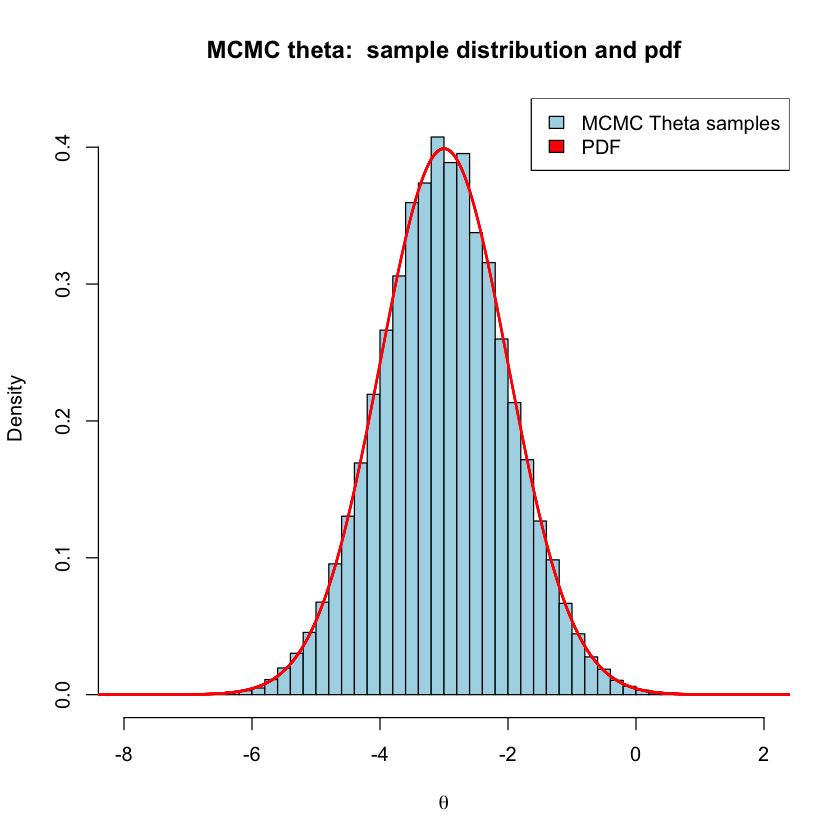

In [4]:
markov_hist <- hist(chain[,2],
                    breaks = 40,
                    plot = TRUE,
                    col = 'lightblue',
                    xlab = expression(theta),
                    xlim = c(-8,2),
                    ylim = c(0, max(y)*1.05),
                    main = 'MCMC theta:  sample distribution and pdf',
                    freq = FALSE)

lines(x, y , 
      col='red',
      lwd = 2)

legend("topright", 
       legend = c("MCMC Theta samples", "PDF"),
       fill = c("lightblue", 'red'))


- use a Norm (0, 1) as random-walk candidate density

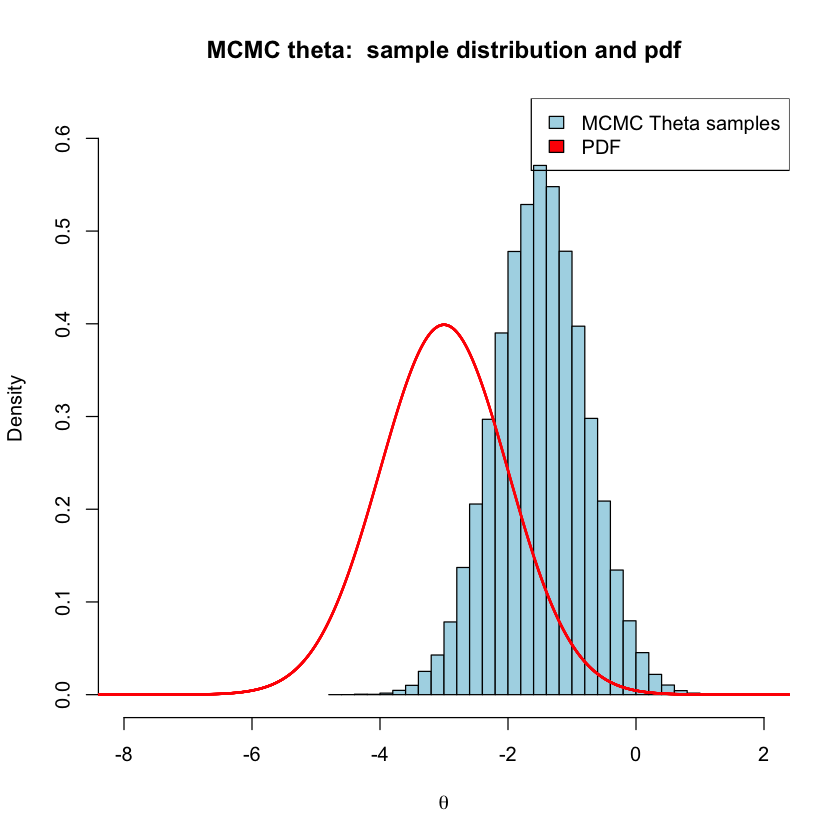

In [5]:
n_sample   <- 1000000
sample_sig = 1
x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact


metropolis_norm <-  function(func, theta_init, n_sample, sigma){
    theta_cur <- theta_init
    func_curr <- func(theta_cur)
    func_samp <- matrix(data=NA, nrow=n_sample, ncol=2+1)


    for (n in 1:n_sample) {
        theta_candidate <- rnorm(n=1, mean = 0, sigma)
        func_candidate <- func(theta_candidate)
        Markov_ratio <- (func_candidate/func_curr)
        
        if(Markov_ratio > runif(1)){
            theta_cur <- theta_candidate
            func_curr <- func_candidate   
        }
        else{
            theta_cur <- theta_cur
            func_curr <- func_curr
        }

        func_samp[n,1] <- func_curr
        func_samp[n,2] <- theta_cur
    }
    return (func_samp)
}

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
chain <- metropolis_norm(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

markov_hist <- hist(chain[,2],
breaks = 40,
plot = TRUE,
col = 'lightblue',
xlab = expression(theta),
xlim = c(-8,2),
ylim = c(0, max(y)*1.55),
main = 'MCMC theta:  sample distribution and pdf',
freq = FALSE)

lines(x, y , 
      col='red',
      lwd = 2)

legend("topright", 
       legend = c("MCMC Theta samples", "PDF"),
       fill = c("lightblue", 'red'))


- plot the sampled distribution

In [6]:
# Plotted above: the shape of the sample distribution is heavly influenced by the random walk candidate distribution

- analyze the chain with the CODA package and plot the chain autocorrelation


In [6]:
library(coda)
theta_init <- 1
sample_sig <- 5 
n_sample   <- 1000000

x <- seq(-10, 10, length.out=n_sample) 
y <- post(x)/norm_fact
chain <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig^2)

mcmc_chian_obj <- mcmc(data=chain[,2])

summary(mcmc_chian_obj)


Iterations = 1:1e+06
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+06 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     -3.000718       1.001748       0.001002       0.005400 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-4.973 -3.679 -2.997 -2.323 -1.047 


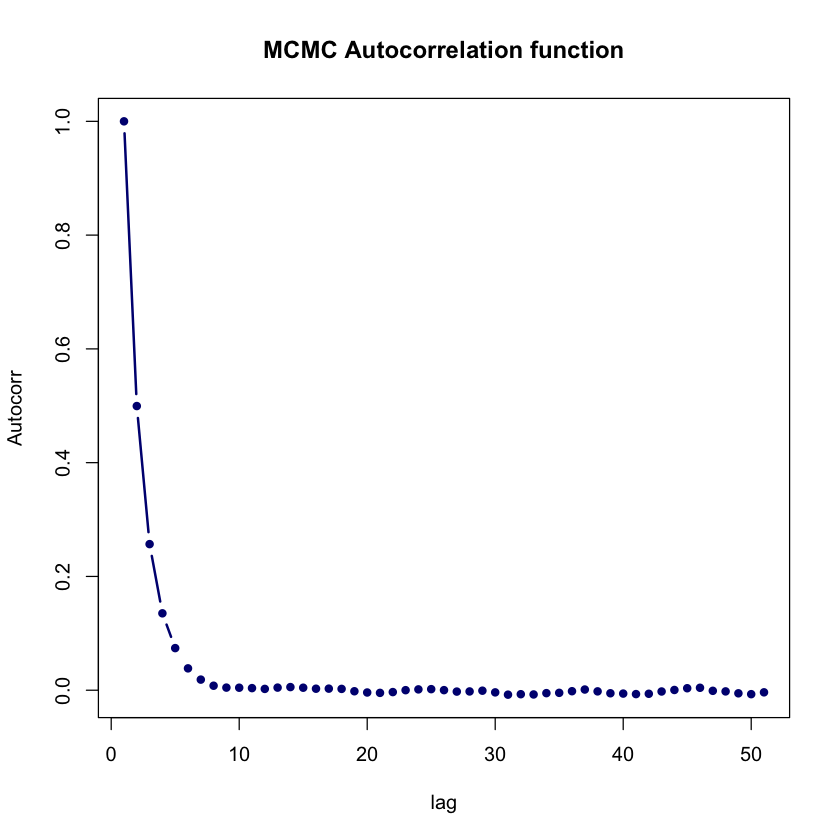

In [13]:
my_lags = seq(0,500,10)
autocorr_mcmc <- autocorr(mcmc_chian_obj, lags=my_lags)
plot(autocorr_mcmc,
     col = 'navy',
     type = 'b',
     pch = 20,
     lwd = 2,
     main = 'MCMC Autocorrelation function',
     ylab = 'Autocorr',
     xlab = 'lag')

- try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?


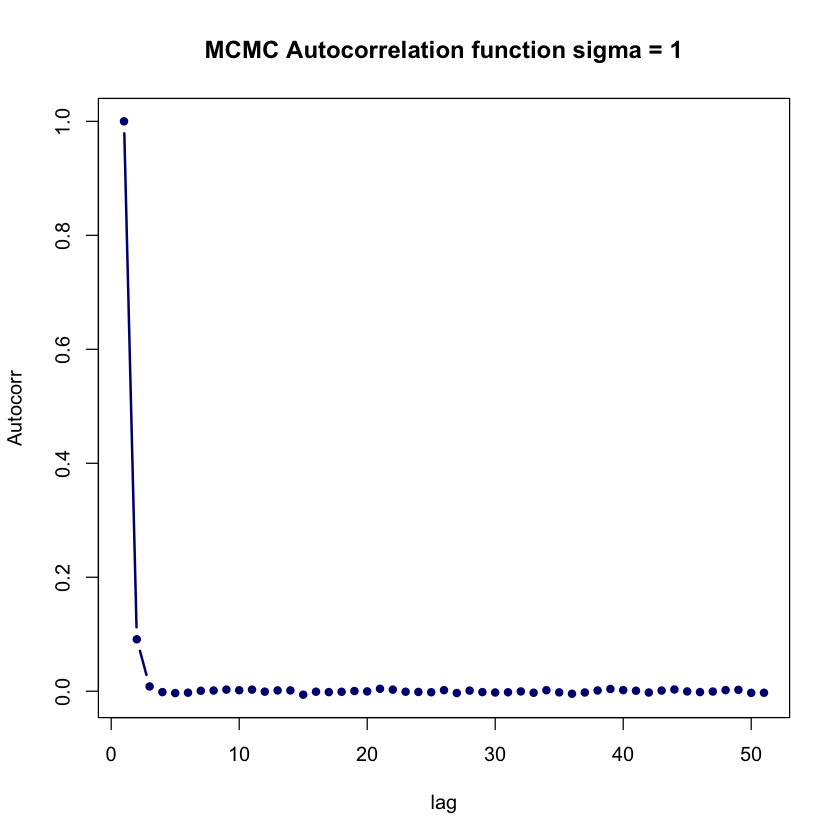

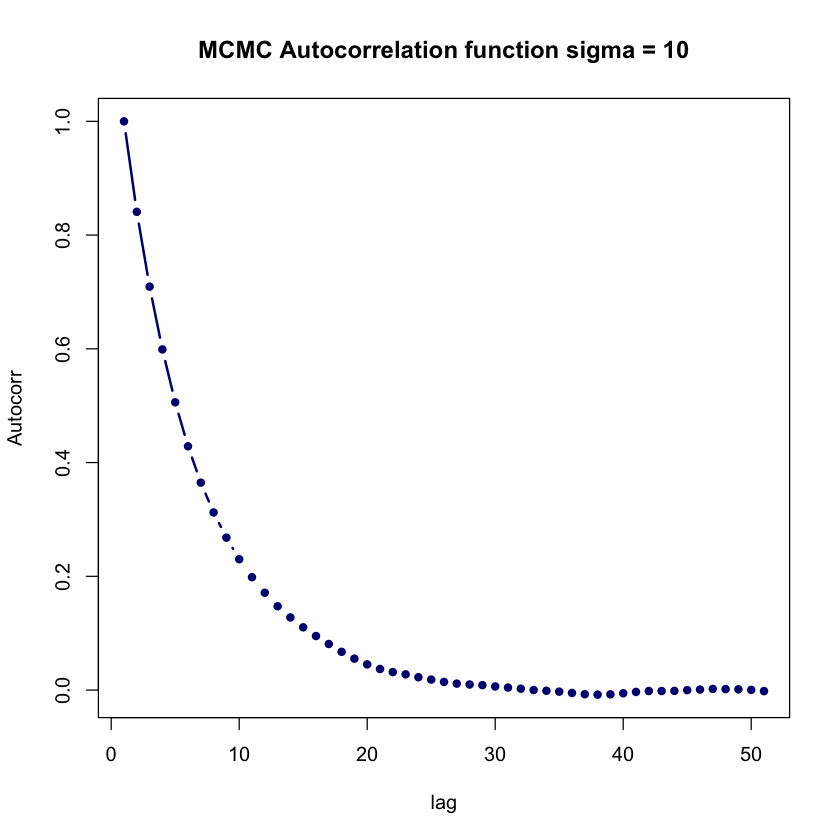

In [14]:
sample_sig_1 <- 1 
chain_1 <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig_1^2)
mcmc_chian_obj_1 <- mcmc(data=chain_1[,2])
autocorr_mcmc_1 <- autocorr(mcmc_chian_obj_1, lags=my_lags)

sample_sig_2 <- 10
chain_2 <- metropolis(func = post ,
                    theta_init = theta_init, 
                    n_sample = n_sample,
                    sigma = sample_sig_2^2)
mcmc_chian_obj_2 <- mcmc(data=chain_2[,2])
autocorr_mcmc_2 <- autocorr(mcmc_chian_obj_2, lags=my_lags)

plot(autocorr_mcmc_1,
     col = 'navy',
     type = 'b',
     pch = 20,
     lwd = 2,
     main = 'MCMC Autocorrelation function sigma = 1',
     ylab = 'Autocorr',
     xlab = 'lag')

plot(autocorr_mcmc_2,
     col = 'navy',
     type = 'b',
     pch = 20,
     lwd = 2,
     main = 'MCMC Autocorrelation function sigma = 10',
     ylab = 'Autocorr',
     xlab = 'lag')

# EX 2

In [15]:
library(rjags)

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:


Y = [7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.32]\
X = [5, 6, 7, 8, 9, 10, 11, 12]


- perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS,assuming that data follow the model:\
$Z[i] = a + b * X[i]$

- and the likelihood of the measured data follow a Gaussian likelihood distribution:    
 $Y[i] ~dnorm(Z[i], c)$


- run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.

In [16]:
data <- NULL
data$X <- c(5, 6, 7, 8, 9, 10, 11, 12)
data$Y <- c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)

inits <- NULL
inits$a <- runif(1, 1, 10)
inits$b <- runif(1, -1, 3)
inits$c <- runif(1, 0.034, 4)

jm <- jags.model("linear_model.bug", data, inits)
update(jm, n.iter = 500000)
chain <- coda.samples(jm, c('a','b', 'c'),n.iter = 500000, thin = 50)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model




Iterations = 501050:1001000
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
a  1.47736 0.462082 4.621e-03      4.621e-03
b -0.94738 0.051115 5.111e-04      5.011e-04
c  0.04422 0.009685 9.685e-05      9.374e-05

2. Quantiles for each variable:

      2.5%      25%      50%      75%    97.5%
a  1.01290  1.13931  1.33152  1.67678  2.70649
b -0.99872 -0.98395 -0.96229 -0.92696 -0.81163
c  0.03429  0.03711  0.04154  0.04828  0.06938



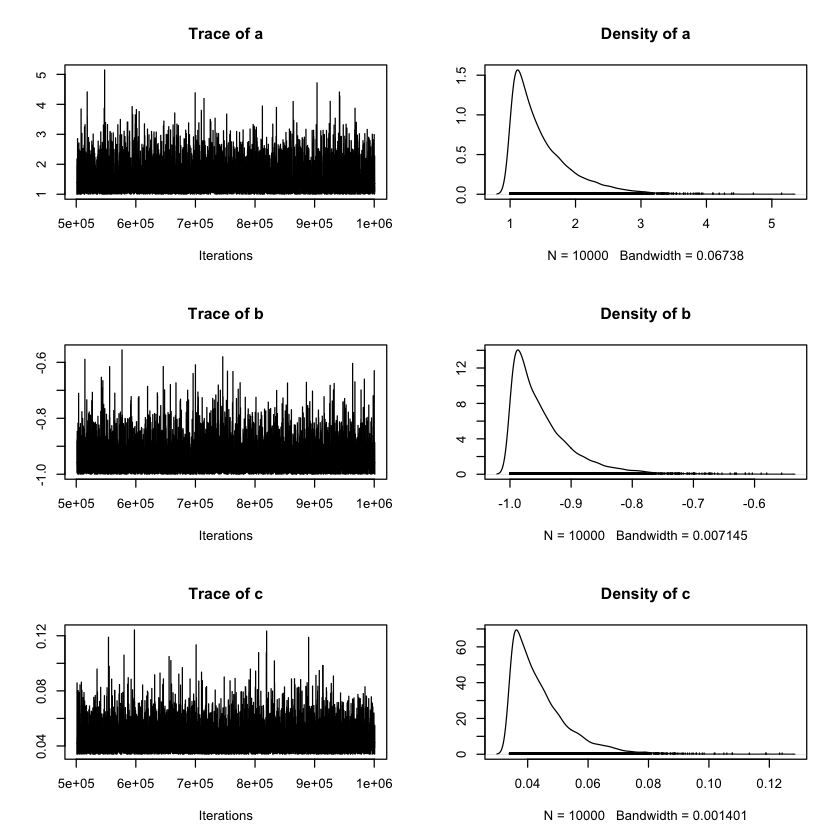

In [17]:
sch <- summary(chain)
print(sch)
plot(chain)

- using the obtained posterior distributions, compute the posterior distribution of\
$ \sigma = \sqrt{\frac{1}{c}} $

# EX 3

suppose we observe the following values

 - 2.06, 5.56, 7.93, 6.56, 205

and we assume that the data come from a gaussian distribution with unknown mean m and variance s2

build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance.

In [26]:
data <- NULL
data$X <- c(2.06, 5.56, 7.93, 6.56, 205)

inits <- NULL
inits$m <- runif(1,-10, 10)
inits$s <- runif(1, 0,50)


jm <- jags.model("gaussian_model.bug", data, inits)
update(jm, n.iter = 5000000)
chain <- coda.samples(jm, c('m','s'),n.iter = 5000000, thin = 50)


Warning message in jags.model("gaussian_model.bug", data, inits):
"Unused variable "X" in data"


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 0
   Unobserved stochastic nodes: 7
   Total graph size: 11

Initializing model




Iterations = 5000050:1e+07
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
m -0.005703  5.766  0.01823        0.01823
s 25.008120 14.469  0.04575        0.04555

2. Quantiles for each variable:

    2.5%    25%      50%    75%  97.5%
m -9.485 -4.993 -0.00956  4.985  9.502
s  1.222 12.419 25.00451 37.564 48.775


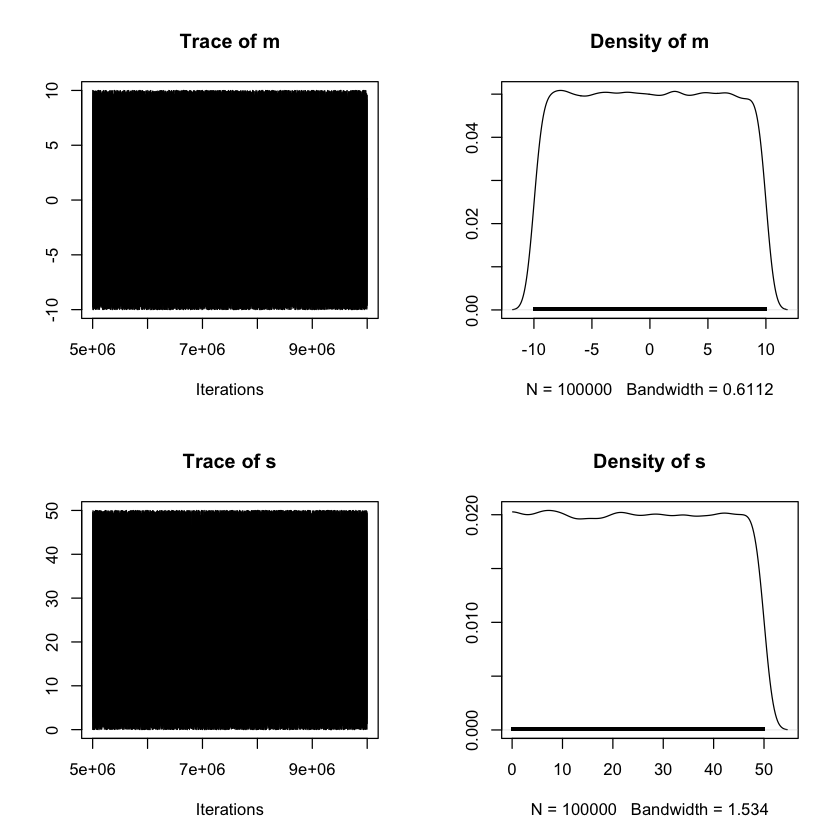

In [21]:
summary(chain)
plot(chain)

# EX 4

The data set that Edwin Hubble ised to show that galaxies are moving either away or towards us are given in the following table:

- Using this data set define a JAGS model to fit data with the following: V[i] ~dnorm(b * D[i], c)
- where V represent the velocity in units of km/s, D is the observed distance (in units of parsec), and b and c are two parameters of the model
- assume whatever prior distribution you think is appropriate
- plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility interval

In [61]:
data <- NULL
data$V <- c(170,290,-130,-70,-185,-220,200,290,270,200,290,450,500,500,960,500,850,800,1090)
data$D <- c(0.0032,0.0034,0.214,0.263,0.275,0.275,0.45,0.5,0.5,0.63,0.8,0.9,0.9,0.9,0.9,2,2,2,2)


inits <- NULL
inits$b <- rbeta(1, 1, 1)
inits$c <- rbeta(1, 1, 1)

jm <- jags.model("Hubble_model.bug ", data, inits)
update(jm, n.iter = 300000)
chain <- coda.samples(jm, c('b','c'),n.iter = 300000, thin = 50)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 55

Initializing model



In [62]:
summary(chain)


Iterations = 301050:601000
Thinning interval = 50 
Number of chains = 1 
Sample size per chain = 6000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
b 3.548e+02 8.561e+01 1.105e+00      1.105e+00
c 7.840e-06 2.515e-06 3.247e-08      3.247e-08

2. Quantiles for each variable:

       2.5%       25%       50%       75%     97.5%
b 1.876e+02 2.998e+02 3.544e+02 4.107e+02 5.226e+02
c 3.640e-06 6.059e-06 7.563e-06 9.326e-06 1.349e-05


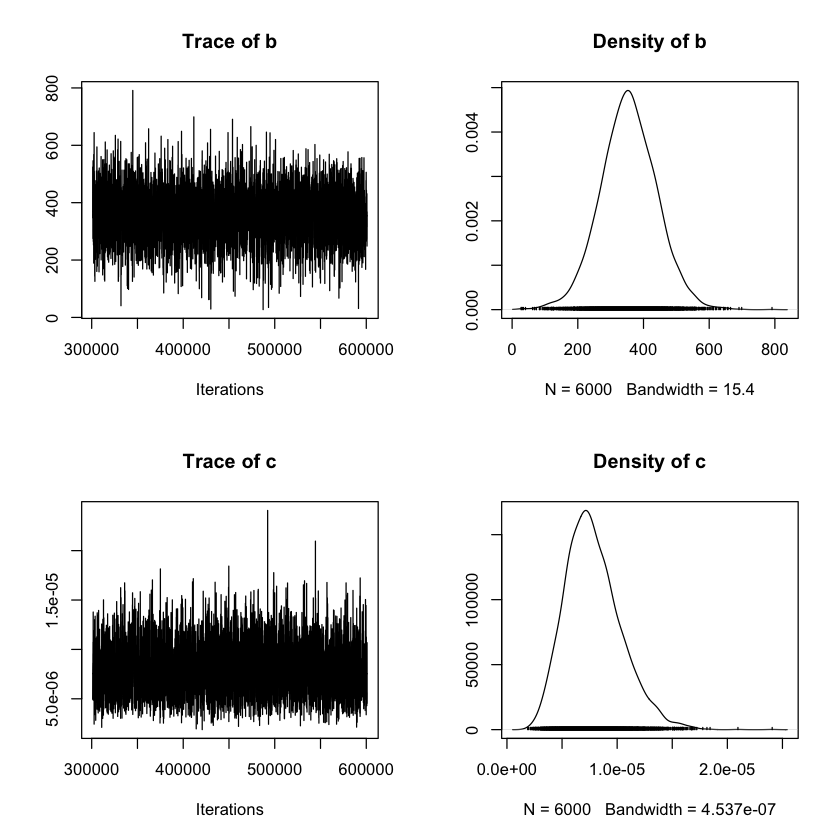

In [63]:
plot(chain)